In [156]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns
import sklearn
from random import sample 
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale,resize

import os

In [30]:
images_dir = "images"
labels_path = 'sample_labels.csv'
all_photos_paths = [os.path.join(images_dir,file) for file in os.listdir(images_dir)]
print(all_photos_paths[:4])
metadata = pd.read_csv(labels_path)

['images/00016522_016.png', 'images/00018500_009.png', 'images/00002570_001.png', 'images/00018055_015.png']


In [31]:
metadata.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [32]:
metadata.shape

(5606, 11)

Some photos consist of several illnesses. Let's split it so that every row has only 1 illness or no illness assigned

In [33]:
df = metadata # metadata is too long name :)
s = df['Finding Labels'].str.split('|').apply(pd.Series, 1).stack()   
s.index = s.index.droplevel(-1)
s.name = 'Illness'
del df['Finding Labels']
df = df.join(s)

In [43]:
Illness = 'Illness'
df.columns

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Illness'],
      dtype='object')

In [44]:
df[Illness].head(10)

0             Emphysema
0          Infiltration
0    Pleural_Thickening
0          Pneumothorax
1          Cardiomegaly
1             Emphysema
2            No Finding
3           Atelectasis
4          Cardiomegaly
4                 Edema
Name: Illness, dtype: object

In [39]:
df[Illness].count()

6978

In [75]:
all_illnesses = df[Illness].unique()
grouped = df.groupby([Illness]).size().reset_index(name='Count')
grouped

,Illness,Count
0,Atelectasis,508
1,Cardiomegaly,141
2,Consolidation,226
3,Edema,118
4,Effusion,644
5,Emphysema,127
6,Fibrosis,84
7,Hernia,13
8,Infiltration,967
9,Mass,284


<br>Let's plot and see how many of illnes do we have in dataset</br>

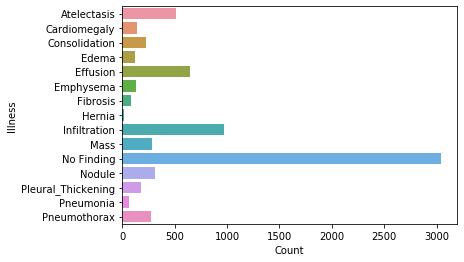

In [76]:
sns.barplot(y=Illness,x='Count',data = grouped)

<br> Now with "No finding" filtered out</br>

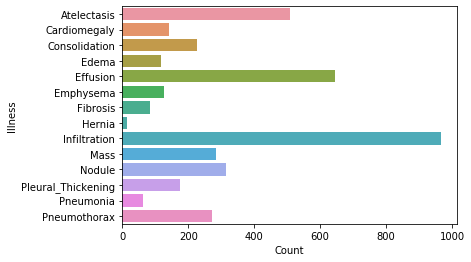

In [77]:
sns.barplot(y=Illness,x='Count',data = grouped[grouped[Illness]!='No Finding'])

From now we'll make thing easier and take just healthy people and these which have Infiltration to perform binary classification

In [89]:
df_bin = df[df.Illness.isin(['No Finding','Infiltration'])]
df_bin.shape

(4011, 11)

We still have most of our data, as we started with 5606 samples. That means that 4011 out of these are either healthy or suffer rom Infiltration

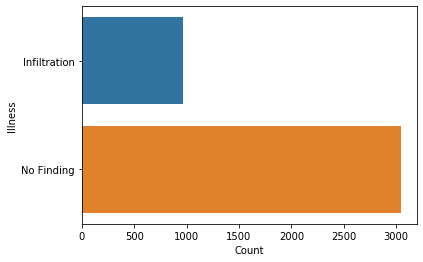

In [92]:
grouped = df_bin.groupby([Illness]).size().reset_index(name='Count')
sns.barplot(y=Illness,x='Count',data = grouped)

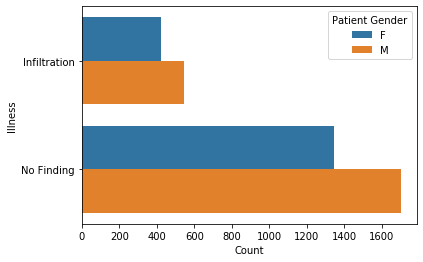

In [95]:
grouped = df_bin.groupby(['Patient Gender',Illness]).size().reset_index(name='Count')
sns.barplot(y=Illness,x='Count',hue='Patient Gender',data = grouped)

we still suffer from some imbalance. We have to remember about it when computing future model's accuracy. There is also a little overrepresentation of men comparing to women, however it's proportional in both classes, so possibly can be ommitted

<br> Let's take a look at some photos</br>


/home/robert/PycharmProjects/medCollaboratory/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


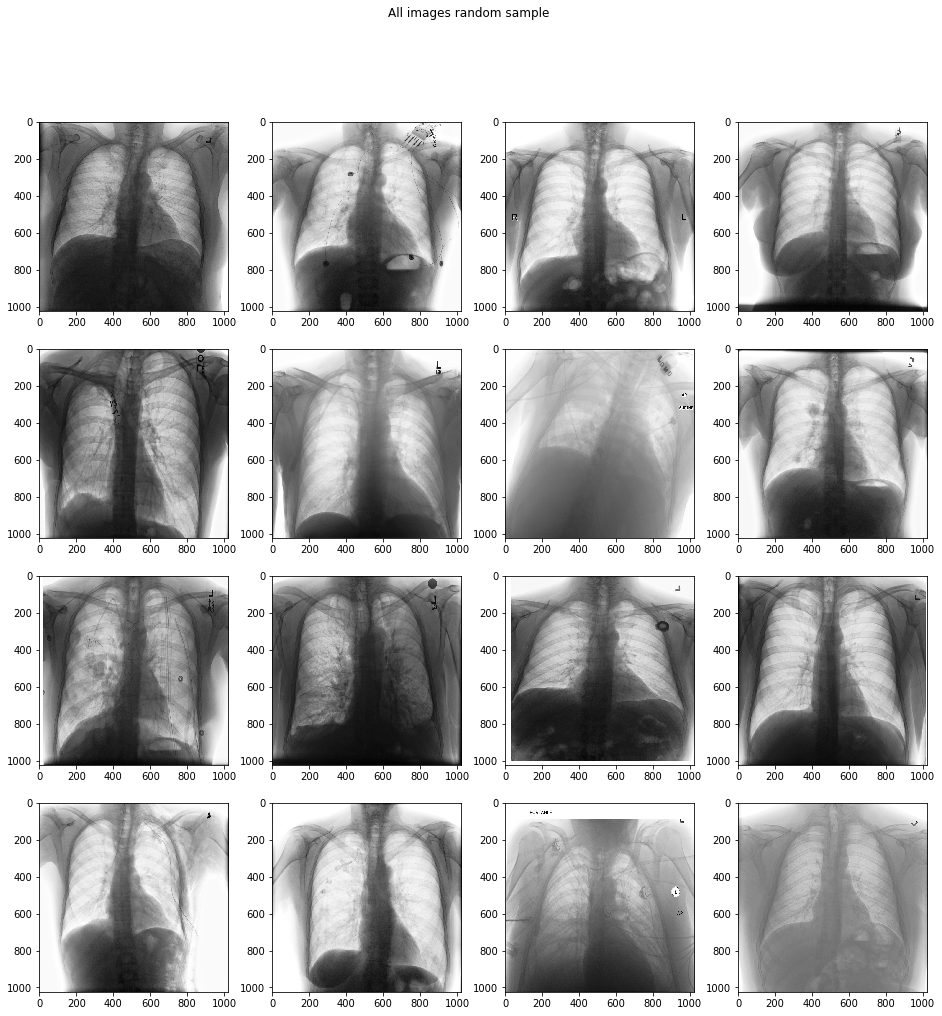

In [122]:
def draw(photos,figsize,title):
    x,y = figsize
    fig,ax = plt.subplots(x,y,figsize=(x*4,y*4))
    for i,path in enumerate(sample(photos,x*y)):
        with open(path,'rb') as f:
            image=Image.open(f)
            ax[i%x,i//y].imshow(image, cmap='Greys')
    plt.suptitle(title)
    fig.show()
draw(all_photos_paths,(4,4), "All images random sample")

<class 'numpy.ndarray'>


/home/robert/PycharmProjects/medCollaboratory/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


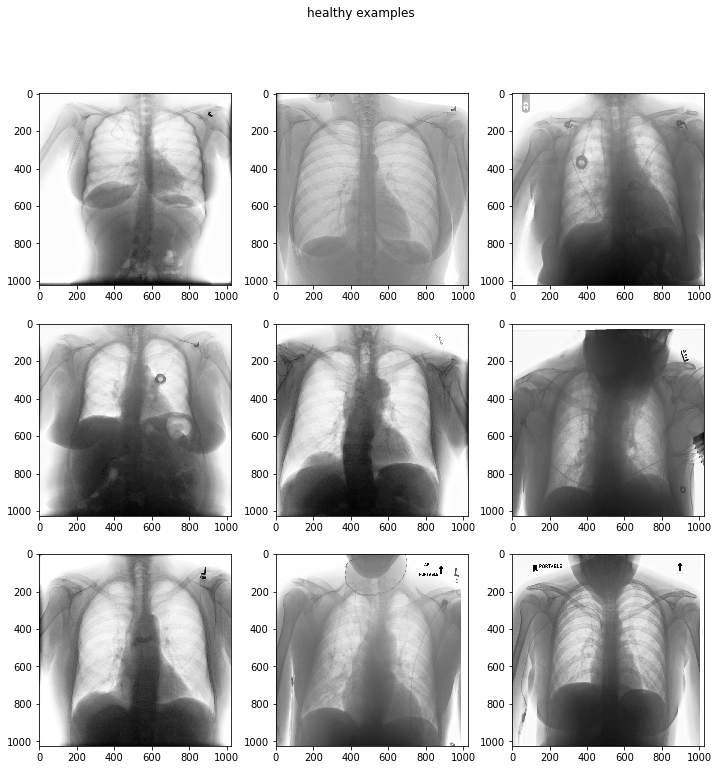

In [125]:
healthy= df_bin[df_bin[Illness]=='No Finding'][['Image Index']]\
.apply(lambda path: images_dir+"/"+path).values.flatten()
sick= df_bin[df_bin[Illness]=='Infiltration'][['Image Index']]\
.apply(lambda path: images_dir+"/"+path).values.flatten()
print(type(healthy))
draw(list(healthy),(3,3),"healthy examples")


/home/robert/PycharmProjects/medCollaboratory/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


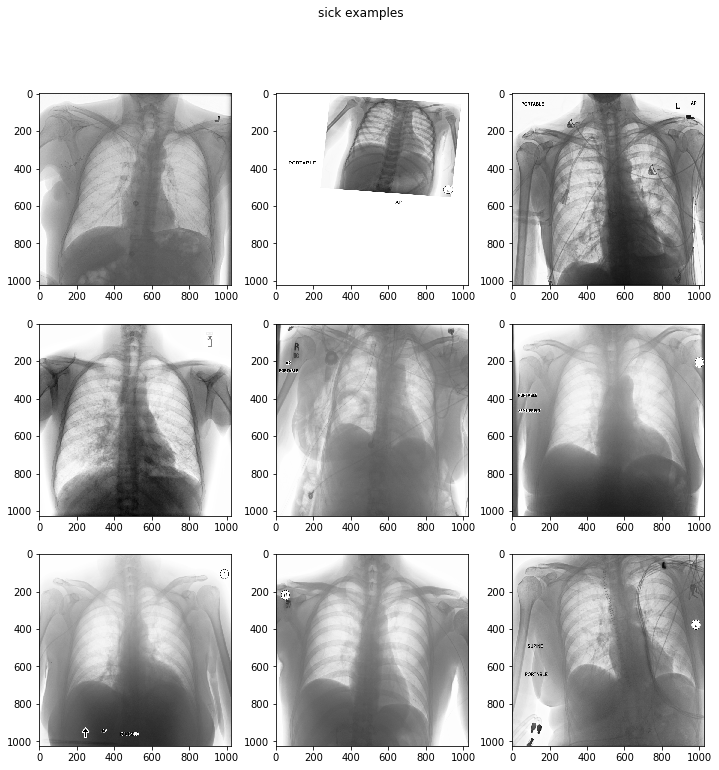

In [127]:
draw(list(sick),(3,3),"sick examples")

Ok, Let'ś start doing something! First, let's check if the images are of fixed size. We'd like to vectorize them after all.


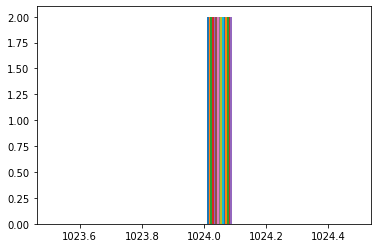

In [129]:
plt.hist([Image.open(file).size for file in all_photos_paths)
plt.show()
# the chart is actually ugly but all the photos have the same size. However 1024x1024 seems to be too much for our 
# computers, so let's resize them:

In [174]:
WIDTH,HEIGHT =256,256

We will use Histogram of Oriented Gradients to reduce number of features and because it's cool :)

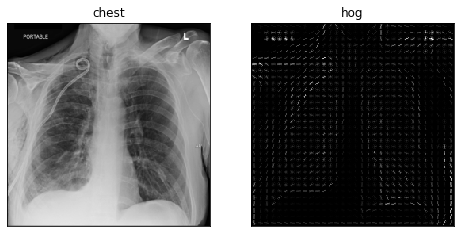

In [170]:
chest = imread(all_photos_paths[3], as_grey=True)

chest = resize(chest, (WIDTH,HEIGHT),anti_aliasing=True)
# calculate the hog and return a visual representation.
chest_hog, dog_hog_img = hog(
    chest, pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=8,
    visualise=True,
    block_norm='L2-Hys')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for a in ax]

ax[0].imshow(chest, cmap='gray')
ax[0].set_title('chest')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [173]:
print('pixels: ', chest.shape[0] * chest.shape[1])
print('hog features: ', chest_hog.shape[0])

pixels:  65536
hog features:  30752


as we can see - hog representation reduces number of features for over 50% in this particular example

In [175]:
import dill
dill.dump_session('notebook_env.db')

# from sklearn.model_selection import train_test_split




# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size=0.2,
#     shuffle=True,
# )


ValueError: ctypes objects containing pointers cannot be pickled